In [3]:
# Install, import libraries
import sys
!{sys.executable} -m pip install python-dotenv pandas pydap geopandas

import geopandas as gpd
import pandas as pd
from pydap.client import open_url
from pydap.cas.urs import setup_session

import xarray as xr

%load_ext dotenv
%dotenv
from os import environ

  Using cached python_dotenv-0.11.0-py2.py3-none-any.whl (17 kB)


In [91]:
datasets = [ ## TODO automate the consturction of this list
    "2020/oco2_LtCO2_200101_B9003r_200204190325s.nc4",
#     "2020/oco2_LtCO2_200102_B9003r_200204190440s.nc4",
#     "2020/oco2_LtCO2_200103_B9003r_200204190754s.nc4",
#     "2020/oco2_LtCO2_200108_B9003r_200204190946s.nc4",
#     "2020/oco2_LtCO2_200109_B9003r_200204191010s.nc4",
#     "2020/oco2_LtCO2_200110_B9003r_200204191136s.nc4",
#     "2020/oco2_LtCO2_200111_B9003r_200204191415s.nc4",
#     "2020/oco2_LtCO2_200112_B9003r_200204191626s.nc4",
#     "2020/oco2_LtCO2_200113_B9003r_200204191752s.nc4",
#     "2020/oco2_LtCO2_200114_B9003r_200204192011s.nc4",
#     "2020/oco2_LtCO2_200115_B9003r_200204192230s.nc4",
#     "2020/oco2_LtCO2_200116_B9003r_200204192449s.nc4",
#     "2020/oco2_LtCO2_200117_B9003r_200204192650s.nc4",
#     "2020/oco2_LtCO2_200118_B9003r_200204192849s.nc4",
#     "2020/oco2_LtCO2_200119_B9003r_200204193103s.nc4",
#     "2020/oco2_LtCO2_200120_B9003r_200204193223s.nc4",
#     "2020/oco2_LtCO2_200121_B9003r_200204193452s.nc4"
]

In [7]:
data = []
test = False
# Download OCO-2 C02 data
for i, path in enumerate(datasets):
    dataset_url = "https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L2_Lite_FP.9r/" + path
    print(f"Loading dataset #{i} {dataset_url}")
    session = setup_session(environ.get("EARTHDATA_USER"), environ.get("EARTHDATA_PASS"), check_url=dataset_url)
    dataset = open_url(dataset_url, session=session)
    test = dataset
    data += list(zip(dataset['latitude'], dataset['longitude'], dataset['xco2'], dataset['time'], dataset['vertex_latitude'], dataset['vertex_longitude']))

Loading dataset #0 https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L2_Lite_FP.9r/2020/oco2_LtCO2_200101_B9003r_200204190325s.nc4


In [8]:
df = pd.DataFrame(data, columns=['latitude', 'longitude', 'xco2', 'time', 'vertex_latitude', 'vertex_longitude'])
gdf = gpd.GeoDataFrame(df['xco2'], geometry=gpd.points_from_xy(df.longitude, df.latitude))

df

,latitude,longitude,xco2,time,vertex_latitude,vertex_longitude
0,-63.118465,-144.780121,404.065430,1.577837e+09,"[-63.128063, -63.11009, -63.11152, -63.12949]","[-144.75716, -144.76743, -144.80132, -144.79108]"
1,-63.089653,-145.002289,406.500885,1.577837e+09,"[-63.099724, -63.081955, -63.083344, -63.101093]","[-144.97961, -144.98961, -145.02255, -145.0126]"
2,-63.053177,-144.988388,407.557800,1.577837e+09,"[-63.063282, -63.045532, -63.046917, -63.064663]","[-144.96591, -144.97589, -145.00949, -144.99954]"
3,-63.029068,-144.831039,407.300293,1.577837e+09,"[-63.038544, -63.020763, -63.02221, -63.03999]","[-144.80824, -144.81836, -144.85211, -144.84201]"
4,-63.030582,-144.864288,406.024719,1.577837e+09,"[-63.04029, -63.02251, -63.02396, -63.041744]","[-144.84172, -144.85182, -144.88574, -144.87566]"
...,...,...,...,...,...,...
149617,22.195580,-154.423920,410.113220,1.577921e+09,"[22.193356, 22.211308, 22.199863, 22.181913]","[-154.42374, -154.42908, -154.42078, -154.41544]"
149618,22.184349,-154.415802,410.534058,1.577921e+09,"[22.18217, 22.200123, 22.1889, 22.17095]","[-154.41551, -154.42084, -154.41269, -154.40736]"
149619,22.172979,-154.407761,411.006256,1.577921e+09,"[22.170858, 22.188808, 22.17765, 22.1597]","[-154.40741, -154.41273, -154.40463, -154.3993]"
149620,22.161507,-154.399811,410.856110,1.577921e+09,"[22.159412, 22.17736, 22.16597, 22.148024]","[-154.39944, -154.40477, -154.39651, -154.39119]"


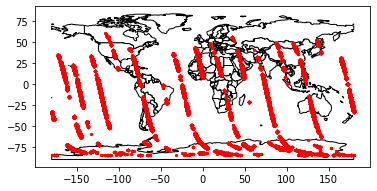

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

base = world.plot(color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', color='red', markersize=5);

In [92]:
import xarray as xr
import requests

final_ds = False
data = []
for i, path in enumerate(datasets):
    dataset_url = "https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L2_Lite_FP.9r/" + path
    print(f"Loading dataset #{i} {dataset_url}")
    session = setup_session(environ.get("EARTHDATA_USER"), environ.get("EARTHDATA_PASS"), check_url=dataset_url)
    store = xr.backends.PydapDataStore.open(dataset_url, session=session)
    ds =  (xr.open_dataset(store)
           [[ 'sounding_id', 'latitude', 'longitude', 'time', 'xco2' ]]
           .set_coords(['latitude', 'longitude', 'time']))
    
    time_dim = smaller.swap_dims({ 'sounding_id': 'time' })
    lat_dim = smaller.swap_dims({ 'sounding_id': 'latitude' })
    long_dim = smaller.swap_dims({ 'sounding_id': 'longitude' })
    
    ds = xr.broadcast(time_dim, lat_dim, long_dim)[0]
    final_ds = final_ds.combine_by_coords(ds) if final_ds else ds
    
## First pass to get metadata from xarray (don't download data)
## Second pass to calculate 
final_ds

Loading dataset #0 https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L2_Lite_FP.9r/2020/oco2_LtCO2_200101_B9003r_200204190325s.nc4


<xarray.Dataset>
Dimensions:      (latitude: 149622, longitude: 149622, time: 149622)
Coordinates:
  * latitude     (latitude) float32 -63.118465 -63.089653 ... 22.149921
  * longitude    (longitude) float32 -144.78012 -145.00229 ... -154.39195
  * time         (time) datetime64[ns] 2020-01-01T00:00:13.921992448 ... 2020-01-01T23:30:16.750006528
    sounding_id  (time) int64 0 1 2 3 4 5 ... 149617 149618 149619 149620 149621
Data variables:
    xco2         (time, latitude, longitude) float32 404.06543 ... 409.88208
Attributes:
    identifier_product_doi:            10.5067/W8QGIYNKS3JC
    identifier_product_doi_authority:  http://dx.doi.org/
    filter_function:                   oco2_xco2_quality_flag_b9
    bc_function:                       oco2_bias_correct_b9
    warn_level_function:               oco2_warn_levels_b8
    Bias_Correction_land:              XCO2_Bias_Corrected = (XCO2_Raw + 0.90...
    Bias_Correction_oceanGL:           XCO2_Bias_Corrected = (XCO2_Raw + 0.24...
    Footprint_bias_land:               Assumed footprint biases in xco2 [ppm]...
    Footprint_bias_oceanGL:            Assumed footprint biases in xco2 [ppm]...
    Bias_Uncertainty:                  Bias correction parameter uncertaintie...
    Note_regarding_bias_correction:    There is some uncertainty in not only ...
    Platform:                          OCO-2
    Sensor:                            OCO-2
    title:                             ACOS L2 Lite Output
    BuildId:                           B8.1.02
    filtering_state:                   Filtered with oco2_lite_file_prefilter...
    creation_date:                     Feb 2020
    contact:                           Chris O'Dell: odell@atmos.colostate.edu